In [1]:
from utils.sdrf import sdrf
from utils import fosr

import utils.data_loader as loader
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch

import utils.torch_resistance_metrics as ermet
import utils.data_loader as loader
import copy
from torch_geometric.data import Data
from utils.GraphWrapper import GraphWrapper
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
N_LINKS = 30
TAU = 1000
GRAPH = ['lolipop', 'cat', 'SBM', 'SBM2', 'PLBottle', 'PLDense', 'PATH'][4]
GRAPH

'PLBottle'

In [12]:
if GRAPH == 'lollipop':
    G = nx. lollipop_graph(4, 5) 
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE = 300

elif GRAPH == 'cat':
    G = nx.Graph()
    G.add_edges_from([(0,1),(0,3),(1,2),(1,3),(1,4),(2,4),(2,11),(3,4),(3,5),
                    (4,5),(5,6),(5,7),(6,7),(6,8),(6,9), (7,9),(7,10),(8,9),
                    (9,10),(10,15),(11,12),(13,14),(14,15),(0,11),(8,15),
                    (13,12) 
                    ])
    pos= nx.kamada_kawai_layout(G)
    G.remove_edge(13,12)
    NODE_SIZE=300
elif GRAPH == 'SBM':
    NODE_SIZE = 100
    NCC=0
    while NCC!=1:
        G = nx.stochastic_block_model([25,25], [[0.3, 0.01], [0.01, 0.3]], seed=42)
        NCC = nx.number_connected_components(G)
    pos= nx.kamada_kawai_layout(G)
elif GRAPH == 'SBM2':
    NODE_SIZE = 60

    G = nx.stochastic_block_model([25,25,35,10], [[0.7, 0.02, 0.02,0],
                                                    [0.02, 0.7, 0.02, 0],
                                                    [0.02,0.02,0.7,0.01],
                                                    [0, 0, 0.01, 0.8]], seed=40)
    groups = {node: 0 if value == 3 else 1 for node, value in nx.get_node_attributes(G, 'block').items()}
    groups_list = np.array([groups[node] for node in G.nodes]) 

    if nx.number_connected_components(G) !=1:
        raise ValueError(f'Graph is not connected. Not Valid seed')
    
    pos= nx.kamada_kawai_layout(G)
elif GRAPH == 'PLBottle':
    G = nx.powerlaw_cluster_graph(500, 2, .9,seed=42) 
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE=30
    #set peripheral nodes as group 0 and central nodes as group 1
    groups = {node: 0 if degree < 4 else 1 for node, degree in G.degree()}
    #flip groups with a probability p
    p = 0.1
    for node in G.nodes:
        if np.random.rand() < p:
            groups[node] = 1 - groups[node]
    groups_list = np.array([groups[node] for node in G.nodes])
elif GRAPH == 'PLDense':
    G = nx.powerlaw_cluster_graph(50, 2, .8,seed=42)
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE=80
elif GRAPH == 'PATH':

    G = nx.Graph()
    G.add_edges_from([(0,1),(1,2),(2,7),
                      (7,8), (8,9), (8,10), (8,11), (9,10), (9,11), (10,11),
                      (0,12), (12,13), (12,14), (15,12), (13,14), (13,15), (14,15),
                      
                    ])
    G = nx.relabel_nodes(G, {node: i for i,node in enumerate(G.nodes)}, copy=True)
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE=70
    
else:
    raise ValueError('Invalid graph type')

In [6]:
#Rename nodes from 0 to Number of nodes
G.number_of_nodes()

500

In [7]:
edge_list = np.array(G.edges())
edge_list = torch.Tensor(np.hstack((edge_list.T, edge_list.T[[1,0],:]))).long()
GW = GraphWrapper(edgelist=edge_list)

Loaded Graph with 500 nodes and 996 edges - L computation mode: exact


In [13]:
#argsort reverse
node_list = np.array(G.nodes())
node_list = torch.Tensor(node_list).long()

In [14]:
#set group 0 the 10 nodes with more Rtot
topisolated = np.argsort(-GW.get_effective_resistance().sum(axis=1).detach().cpu().numpy())[:G.number_of_nodes()//3]
groups = {node: 0 if node in topisolated else 1 for node in G.nodes()}
groups_list = np.array([groups[node] for node in G.nodes])


In [15]:
def draw_G(G,R,ORI_NODE=None, HL=None, ax=None, d_lims=None, color=None, colorbar=True):
    er = R
    #er = nx.floyd_warshall_numpy(G, nodelist = sorted(list(G.nodes)))
    if ORI_NODE is not None:
        color = er[ORI_NODE,:]
    elif color is None:
        color = R.mean(axis=1)

    f, ax = plt.subplots(1, 1, figsize=(4, 3)) if ax is None else ('OUT', ax)
    node_options = {
            "node_size": [NODE_SIZE]*G.number_of_nodes(),
            "node_color": color,
            "cmap": plt.cm.hot_r,
            'pos':pos,
            "alpha": 1,
            "edgecolors": "grey",
            "linewidths": 1,
        }
    edge_options = {
            "width": 2,
            "edge_cmap": plt.cm.seismic,
            "edge_color": 'black',
            'pos':pos,
            "alpha": .2,
        }
    label_options = {
            'pos':pos,
            'font_color':'w',
            'font_size':10,
            'font_weight':'bold',
            'alpha':1
    }

    ordered_nodes_wh_ori = np.arange(G.number_of_nodes())
    if ORI_NODE is not None: node_options['node_size'][ORI_NODE] = 0 
    if d_lims is not None:
        d_min, d_max = d_lims
    else:
        d_min, d_max = color.min(), color.max()

    nx.draw_networkx_nodes(G, nodelist = ordered_nodes_wh_ori, **node_options, ax=ax,
                        vmin = d_min, vmax = d_max,)
    if ORI_NODE is not None:
        nx.draw_networkx_nodes(G, nodelist = [ORI_NODE], pos=pos, node_color='black', ax=ax, node_shape='*')
    nx.draw_networkx_edges(G, **edge_options, ax=ax)
    if HL:
        hl_edges = nx.draw_networkx_edges(G, pos=pos, edgelist=HL, edge_color='lightgreen', ax=ax, width= 1.5, alpha=.6)
        #draw nodes of the HL edges
        #hl_nodes = nx.draw_networkx_nodes(G, nodelist = np.unique(HL), pos=pos,
        #                                  node_color=node_options['node_color'][np.unique(HL)],
        #                                 edgecolors='grey', node_size=300, linewidths= 1, ax=ax)
        hl_edges.set_zorder(20)
        #hl_nodes.set_zorder(21)

    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=node_options['cmap'], 
                                norm=plt.Normalize(vmin=d_min, vmax=d_max))
        cbar = plt.colorbar(sm, shrink=.8, aspect=10, ax=ax)
    ax.axis('off')
        #ticklabs = cbar.ax.get_yticklabels()
        #cbar.ax.set_yticklabels(ticklabs, fontsize=12)

    if f != 'OUT':
        plt.tight_layout()
        plt.show()

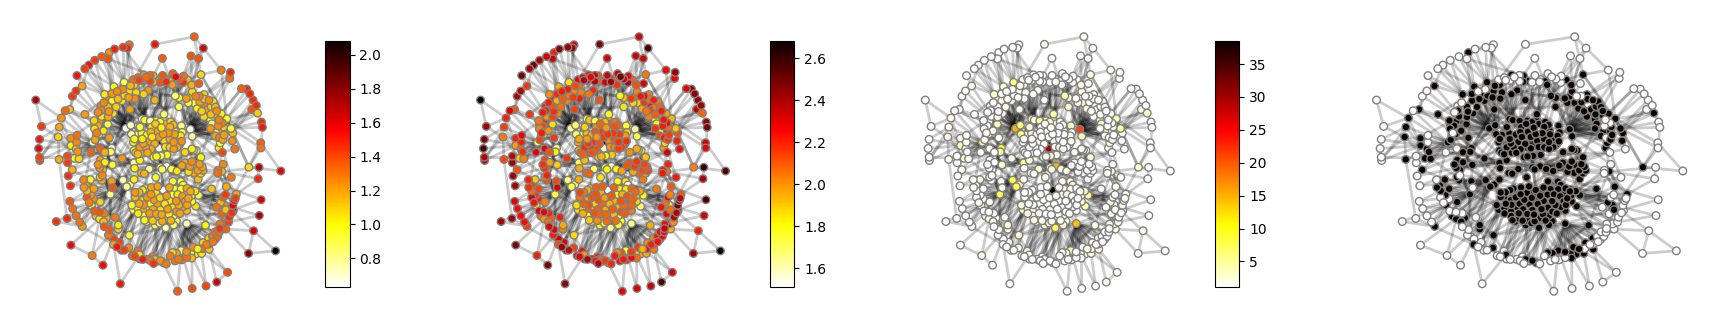

In [16]:
f, axs = plt.subplots(1, 4, figsize=(22, 4))
draw_G(G, R=GW.get_effective_resistance(), ax=axs[0])
draw_G(G, R=GW.get_effective_resistance(), color=GW.get_effective_resistance().max(axis=1)[0], ax=axs[1])
draw_G(G, R=GW.get_effective_resistance(), color=(GW.get_effective_resistance()*~GW.edge_mask).sum(axis=1), ax=axs[2])
draw_G(G, R=GW.get_effective_resistance(), color=groups_list, ax=axs[3], colorbar=False)

**SDRF**

In [17]:
GW1, added_links_sdrf = sdrf(copy.deepcopy(GW), loops=N_LINKS, remove_edges=False, removal_bound=2, is_undirected=True, tau=TAU)
G_sdrf = G.copy()
for e in added_links_sdrf:
    G_sdrf.add_edge(e[0],e[1])

100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


In [18]:
len(added_links_sdrf)

30

**FOSR**

In [19]:
new_edgelist_fosr = fosr.edge_rewire(copy.deepcopy(GW).edgelist.numpy(), num_iterations=N_LINKS, initial_power_iters=50)[0]
# added_links_fosr to list
added_links_fosr = new_edgelist_fosr[:,-N_LINKS*2:].T.tolist()
G_fosr = G.copy()
for e in added_links_fosr:
    G_fosr.add_edge(e[0],e[1])
GW_fosr = GraphWrapper(edgelist=torch.LongTensor(new_edgelist_fosr))
len(added_links_fosr[::2])

Loaded Graph with 500 nodes and 1026 edges - L computation mode: exact


30

In [20]:
added_links_fosr = added_links_fosr[::2]

ERG

In [21]:
GW_ERG = copy.deepcopy(GW)
G_ERG = G.copy()
added_links_erg = []
for i in range(N_LINKS):
    R = GW_ERG.get_effective_resistance().cpu().detach()
    argmax = (R* GW_ERG.edge_mask.cpu().detach()).argmax().item() #detach and cpu on call
    n = R.shape[0]
    u, v = divmod(argmax, n)    
    if GW_ERG.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        GW_ERG.add_link(u,v)
        G_ERG.add_edge(u,v)
        added_links_erg.append((u,v))

Cosine

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix

In [23]:
GW_COS = copy.deepcopy(GW)
G_COS = G.copy()

added_links_cos = []
for i in range(N_LINKS):
    edge_index = GW_COS.edgelist.detach().cpu()
    n = GW_COS.num_nodes
    adj_sparse = coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])),
                        shape=(n, n))
    cos_sim = cosine_similarity(adj_sparse)

    cos_sim[torch.logical_not(GW_COS.edge_mask.cpu().detach())]=torch.inf
    argmin = cos_sim.argmin().item()
    n = cos_sim.shape[0] if n is None else n
    u, v = divmod(argmin, n)
    
    if GW_COS.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        GW_COS.add_link(u,v)
        G_COS.add_edge(u,v)
        added_links_cos.append((u,v))

len(added_links_cos)       

30

DW

In [24]:
try:
    from karateclub import DeepWalk

    GW_DW = copy.deepcopy(GW)
    G_DW = G.copy()
    opt_args = {'dim': 128, 'walk_length': 40, 'window_size': 10, 'workers': 4}

    added_links_dw = []
    for i in range(N_LINKS):
        nxG = nx.from_edgelist(GW_DW.edgelist.T.detach().cpu().numpy())
        dw = DeepWalk(dimensions=opt_args['dim'], walk_length=opt_args['walk_length'], window_size=opt_args['window_size'], workers=opt_args['workers'])
        dw.fit(nxG.copy())
        Z = dw.get_embedding()
        S = np.dot(Z, Z.T)
        np.fill_diagonal(S,0)
        S = torch.tensor(S)

        S[torch.logical_not(GW_DW.edge_mask.cpu().detach())]=torch.inf
        argmin = S.argmin().item()
        n = S.shape[0] if n is None else n
        u, v = divmod(argmin, n)

        if GW_DW.is_edge(u,v):
            raise Exception('Edge already exists')
        else:
            GW_DW.add_link(u,v)
            G_DW.add_edge(u,v)
            added_links_dw.append((u,v))
except:
    print('DeepWalk not installed')

DeepWalk not installed


## VIZ

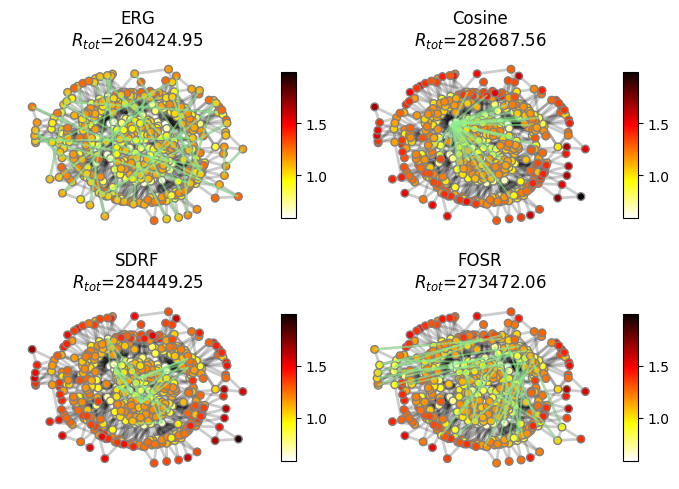

In [25]:
#Create matplotlib subplots, one for each method. Im gonna plot on each subplot the rewired graph with a different method. There are 5 subplots, one for each method.
f, ax = plt.subplots(2, 2, figsize=(7, 5))
ax = ax.flatten()

min_rtot = GW_COS.get_effective_resistance().mean(axis=1).min()
max_rtot = GW_COS.get_effective_resistance().mean(axis=1).max()


ax[0].set_title(f'ERG\n$R_{{tot}}$={GW_ERG.get_effective_resistance().sum():.2f}')
draw_G(G_ERG, R=GW_ERG.get_effective_resistance(), ax=ax[0], HL=added_links_erg, d_lims=(min_rtot, max_rtot))

ax[1].set_title(f'Cosine\n$R_{{tot}}$={GW_COS.get_effective_resistance().sum():.2f}')
draw_G(G_COS, R=GW_COS.get_effective_resistance(), ax=ax[1], HL=added_links_cos, d_lims=(min_rtot, max_rtot))

ax[2].set_title(f'SDRF\n$R_{{tot}}$={GW1.get_effective_resistance().sum():.2f}')
draw_G(G_sdrf, R=GW1.get_effective_resistance(), ax=ax[2], HL=added_links_sdrf, d_lims=(min_rtot, max_rtot))

ax[3].set_title(f'FOSR\n$R_{{tot}}$={GW_fosr.get_effective_resistance().sum():.2f}')
draw_G(G_fosr, R=GW_fosr.get_effective_resistance(), ax=ax[3], HL=added_links_fosr, d_lims=(min_rtot, max_rtot))



plt.tight_layout()
plt.show()
#save figure png
f.savefig(f'results/figures/rewired_graphs/rewiring-{GRAPH}-{N_LINKS}.png', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0, format='png')

In [26]:
N = G.number_of_nodes()

In [27]:
def avg_rtot_disparity(GW, groups_list):
    Rtots = GW.get_effective_resistance().cpu().detach().numpy().mean(axis=1)
    return np.abs(Rtots[groups_list==0].mean() - Rtots[groups_list==1].mean())

def avg_rdiam_disparity(GW, groups_list):
    Rdiam = GW.get_effective_resistance().cpu().detach().numpy().max(axis=1)
    return np.abs(Rdiam[groups_list==0].mean() - Rdiam[groups_list==1].mean())


def avg_bet_disparity(GW, groups_list):
    Rbet = (GW.get_effective_resistance()*~GW.edge_mask).cpu().detach().numpy().sum(axis=1)
    return np.abs(Rbet[groups_list==0].mean() - Rbet[groups_list==1].mean())

In [28]:
#get min Rtot from all the approacches
min_rtot = min(GW_ERG.get_effective_resistance().sum()/N,
               GW_COS.get_effective_resistance().sum()/N,
               GW1.get_effective_resistance().sum()/N,
               GW_fosr.get_effective_resistance().sum()/N)

min_rtot_disp = min(avg_rtot_disparity(GW_ERG, groups_list), avg_rtot_disparity(GW_COS, groups_list), avg_rtot_disparity(GW1, groups_list), avg_rtot_disparity(GW_fosr, groups_list))
min_rdiam_disp = min(avg_rdiam_disparity(GW_ERG, groups_list), avg_rdiam_disparity(GW_COS, groups_list), avg_rdiam_disparity(GW1, groups_list), avg_rdiam_disparity(GW_fosr, groups_list))
min_bet_disp = min(avg_bet_disparity(GW_ERG, groups_list), avg_bet_disparity(GW_COS, groups_list), avg_bet_disparity(GW1, groups_list), avg_bet_disparity(GW_fosr, groups_list))

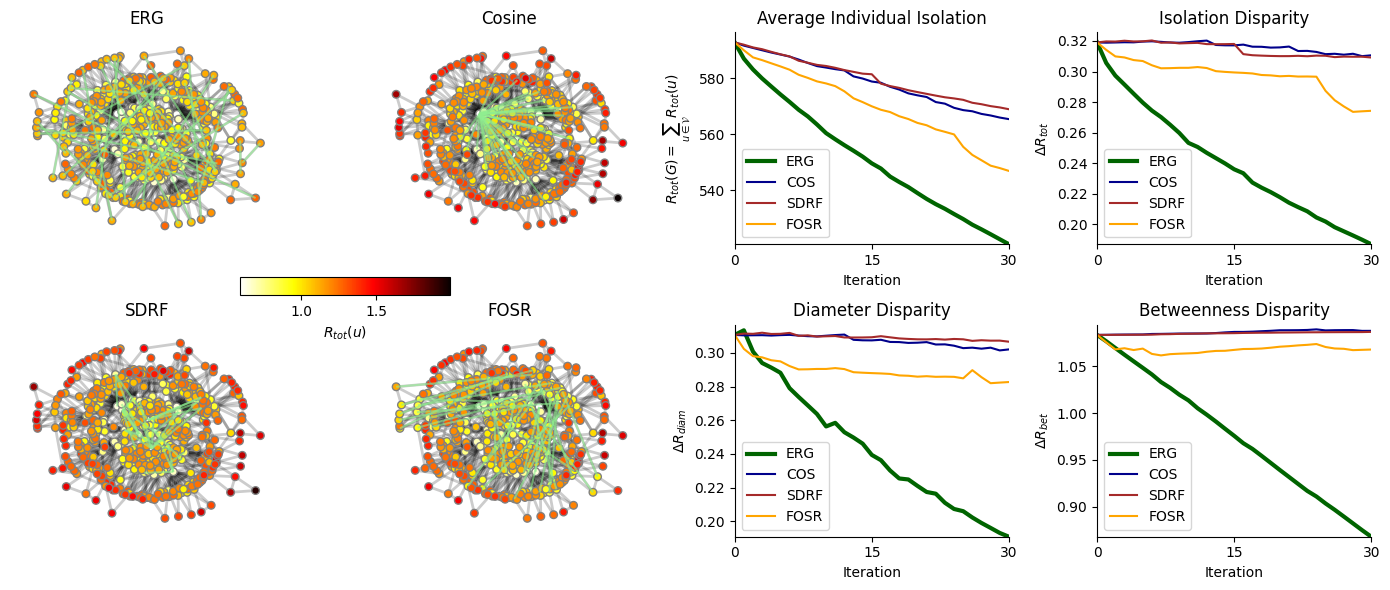

In [29]:
# Function to update the graph in each iteration
import matplotlib.animation as animation

fig, ax = plt.subplots(2, 4, figsize=(14, 6))
ax = ax.flatten()

ori_min_node_er = GW_COS.get_effective_resistance().mean(axis=1).min()
ori_max_node_er = GW_COS.get_effective_resistance().mean(axis=1).max()

sm = plt.cm.ScalarMappable(cmap=plt.cm.hot_r, norm=plt.Normalize(vmin=ori_min_node_er, vmax=ori_max_node_er))
#plt.colorbar(sm, shrink=.8, aspect=10, ax=ax[3])
#horiozntal colorbar in the middle of the figure
cbar_ax = fig.add_axes([0.175, 0.5, 0.15, 0.03])
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('$R_{tot}(u)$')

GW_ERG = copy.deepcopy(GW)
G_ERG = G.copy()

GW_COS = copy.deepcopy(GW)
G_COS = G.copy()

G_sdrf = G.copy()
GW_sdrf = copy.deepcopy(GW)

GW_fosr = copy.deepcopy(GW)
G_fosr = G.copy()

total_ER = {'ERG':[GW_ERG.get_effective_resistance().sum()/N],
            'COS':[GW_COS.get_effective_resistance().sum()/N],
            'SDRF':[GW_sdrf.get_effective_resistance().sum()/N],
            'FOSR':[GW_fosr.get_effective_resistance().sum()/N]}


total_disp_avg_rtot = {'ERG':[avg_rtot_disparity(GW_ERG, groups_list)],
                          'COS':[avg_rtot_disparity(GW_COS, groups_list)],
                          'SDRF':[avg_rtot_disparity(GW_sdrf, groups_list)],
                          'FOSR':[avg_rtot_disparity(GW_fosr, groups_list)]}


total_disp_avg_rdiam = {'ERG':[avg_rdiam_disparity(GW_ERG, groups_list)],
                            'COS':[avg_rdiam_disparity(GW_COS, groups_list)],
                            'SDRF':[avg_rdiam_disparity(GW_sdrf, groups_list)],
                            'FOSR':[avg_rdiam_disparity(GW_fosr, groups_list)]
                            }
                            
total_disp_avg_bet = {'ERG':[avg_bet_disparity(GW_ERG, groups_list)],
                              'COS':[avg_bet_disparity(GW_COS, groups_list)],
                                'SDRF':[avg_bet_disparity(GW_sdrf, groups_list)],
                                'FOSR':[avg_bet_disparity(GW_fosr, groups_list)]
                                }                            

frames = []
def update_graph(frame):
    #add corresponding link to each method
    if frame not in frames:
        frames.append(frame)
        if frame < N_LINKS:
            try:
                GW_ERG.add_link(added_links_erg[frame][0], added_links_erg[frame][1])
                G_ERG.add_edge(added_links_erg[frame][0], added_links_erg[frame][1])

                GW_COS.add_link(added_links_cos[frame][0], added_links_cos[frame][1])
                G_COS.add_edge(added_links_cos[frame][0], added_links_cos[frame][1])

                GW_sdrf.add_link(added_links_sdrf[frame][0], added_links_sdrf[frame][1])
                G_sdrf.add_edge(added_links_sdrf[frame][0], added_links_sdrf[frame][1])

                GW_fosr.add_link(added_links_fosr[frame][0], added_links_fosr[frame][1])
                G_fosr.add_edge(added_links_fosr[frame][0], added_links_fosr[frame][1])
            except:
                pass
            

        #Create matplotlib subplots, one for each method. Im gonna plot on each subplot the rewired graph with a different method. There are 5 subplots, one for each method.
        #plt.clf()
        ax[0].clear()
        ax[0].axis('off')
        ax[0].set_title(f'ERG')
        draw_G(G_ERG, R=GW_ERG.get_effective_resistance(), ax=ax[0], HL=added_links_erg[:frame+1], 
               d_lims=(ori_min_node_er, ori_max_node_er), colorbar=False)

        ax[1].clear()
        ax[1].axis('off')
        ax[1].set_title(f'Cosine')
        draw_G(G_COS, R=GW_COS.get_effective_resistance(), ax=ax[1], HL=added_links_cos[:frame+1],
               d_lims=(ori_min_node_er, ori_max_node_er), colorbar=False)

        ax[4].clear()
        ax[4].axis('off')
        ax[4].set_title(f'SDRF')
        draw_G(G_sdrf, R=GW_sdrf.get_effective_resistance(), ax=ax[4], HL=added_links_sdrf[:frame+1],
               d_lims=(ori_min_node_er, ori_max_node_er), colorbar=False)

        ax[5].clear()
        ax[5].axis('off')
        ax[5].set_title(f'FOSR')
        draw_G(G_fosr, R=GW_fosr.get_effective_resistance(), ax=ax[5], HL=added_links_fosr[:frame+1],
               d_lims=(ori_min_node_er, ori_max_node_er), colorbar=False)

        
        def plot_evol(data,axes,title,ylabel,min_metric):
            axes.clear()
            axes.plot(data['ERG'], label='ERG', color='darkgreen', linewidth=3)
            axes.plot(data['COS'], label='COS', color='darkblue')
            axes.plot(data['SDRF'], label='SDRF', color='brown')
            axes.plot(data['FOSR'], label='FOSR', color='orange')
            axes.set_title(title)
            axes.set_ylabel(ylabel)
            axes.legend()
            axes.set_xlabel('Iteration')
            axes.set_xlim(0, N_LINKS)
            axes.set_ylim(min_metric, data['ERG'][0]+0.05*(data['ERG'][0]-min_metric))
            axes.set_xticks([0, N_LINKS//2, N_LINKS])
            #remove upper and right spines
            axes.spines['top'].set_visible(False)
            axes.spines['right'].set_visible(False)

        

        total_ER['ERG'].append(GW_ERG.get_effective_resistance().sum()/N)
        total_ER['COS'].append(GW_COS.get_effective_resistance().sum()/N)
        total_ER['SDRF'].append(GW_sdrf.get_effective_resistance().sum()/N)
        total_ER['FOSR'].append(GW_fosr.get_effective_resistance().sum()/N)
        plot_evol(total_ER, ax[2], 'Average Individual Isolation', '$R_{tot}(G) = \sum_{u \in \mathcal{V}} R_{tot}(u)$', min_rtot)

        
        total_disp_avg_rtot['ERG'].append(avg_rtot_disparity(GW_ERG, groups_list))
        total_disp_avg_rtot['COS'].append(avg_rtot_disparity(GW_COS, groups_list))
        total_disp_avg_rtot['SDRF'].append(avg_rtot_disparity(GW_sdrf, groups_list))
        total_disp_avg_rtot['FOSR'].append(avg_rtot_disparity(GW_fosr, groups_list))
        plot_evol(total_disp_avg_rtot, ax[3], 'Isolation Disparity', '$\Delta R_{tot}$', min_rtot_disp)


        total_disp_avg_rdiam['ERG'].append(avg_rdiam_disparity(GW_ERG, groups_list))
        total_disp_avg_rdiam['COS'].append(avg_rdiam_disparity(GW_COS, groups_list))
        total_disp_avg_rdiam['SDRF'].append(avg_rdiam_disparity(GW_sdrf, groups_list))
        total_disp_avg_rdiam['FOSR'].append(avg_rdiam_disparity(GW_fosr, groups_list))
        plot_evol(total_disp_avg_rdiam, ax[6], 'Diameter Disparity', '$\Delta R_{diam}$', min_rdiam_disp)

        total_disp_avg_bet['ERG'].append(avg_bet_disparity(GW_ERG, groups_list))
        total_disp_avg_bet['COS'].append(avg_bet_disparity(GW_COS, groups_list))
        total_disp_avg_bet['SDRF'].append(avg_bet_disparity(GW_sdrf, groups_list))
        total_disp_avg_bet['FOSR'].append(avg_bet_disparity(GW_fosr, groups_list))
        plot_evol(total_disp_avg_bet, ax[7], 'Betweenness Disparity', '$\Delta R_{bet}$', min_bet_disp)
         

        plt.tight_layout()
    return fig, ax


  # Create the animation
ani = animation.FuncAnimation(fig, update_graph, frames=N_LINKS, repeat=False)
#Save the animation
ani.save('animation.gif', writer='pillow', fps=10)

# Display the animation
plt.show()